In [ ]:
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib as mpl
import pylab
from ipywidgets import interact, fixed, interactive
import ipywidgets as widgets
from IPython.display import display

In [2]:
#loading the image
img_dir = '/Users/mariavincent/Desktop/hawaii/Spring 2021/699 Data/hd34700/reduc/proc/'
img_name = 'rdiklip.fits'
img = fits.getdata(img_dir+img_name,ext=1)

In [3]:
#to display each cube
def display_cubes(cubes=10):
    # create a figure
    fig = pylab.figure()
    ax = fig.add_subplot(111)
    fig.set_figheight(5)
    fig.set_figwidth(5)
    image = ax.imshow(img[cubes,:,:], cmap=mpl.cm.hot, origin = 'lower',vmin=-0.00009,vmax=0.14)
    cbar = fig.colorbar(image,ax =ax,shrink=0.72)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "%.1f"%((x-100.002)*0.0162)))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "%.1f"%((x-99.9944)*0.0162)))
    ax.set_xlim([50,150])
    ax.set_ylim([50,150])
    ax.set_xlabel(r'$\Delta$ RA [arcsec]')
    ax.set_ylabel(r'$\Delta$ Dec [arcsec]')
    fig.canvas.draw()
# # cbar.ax.tick_params(labelsize=13);
# # ax.tick_params(direction='in', which = 'major',length=5);

#display the plot with a slider to move between cubes
interactive_plot = interactive(display_cubes,cubes=(0,22,1))
output = interactive_plot.children[-1]
output.layout.height = '550px'
output.layout.width = '550px'
interactive_plot

interactive(children=(IntSlider(value=10, description='cubes', max=22), Output(layout=Layout(height='550px', w…

In [4]:
#save image
plt.savefig('rdi_img.png')

In [5]:
# load the .FITS file into a 2-D array (image) and header dictionary (header)
data = fits.open(img_dir+img_name)
image = np.squeeze(data[1].data)[10,:,:]
header = data[1].header

<IPython.core.display.Javascript object>


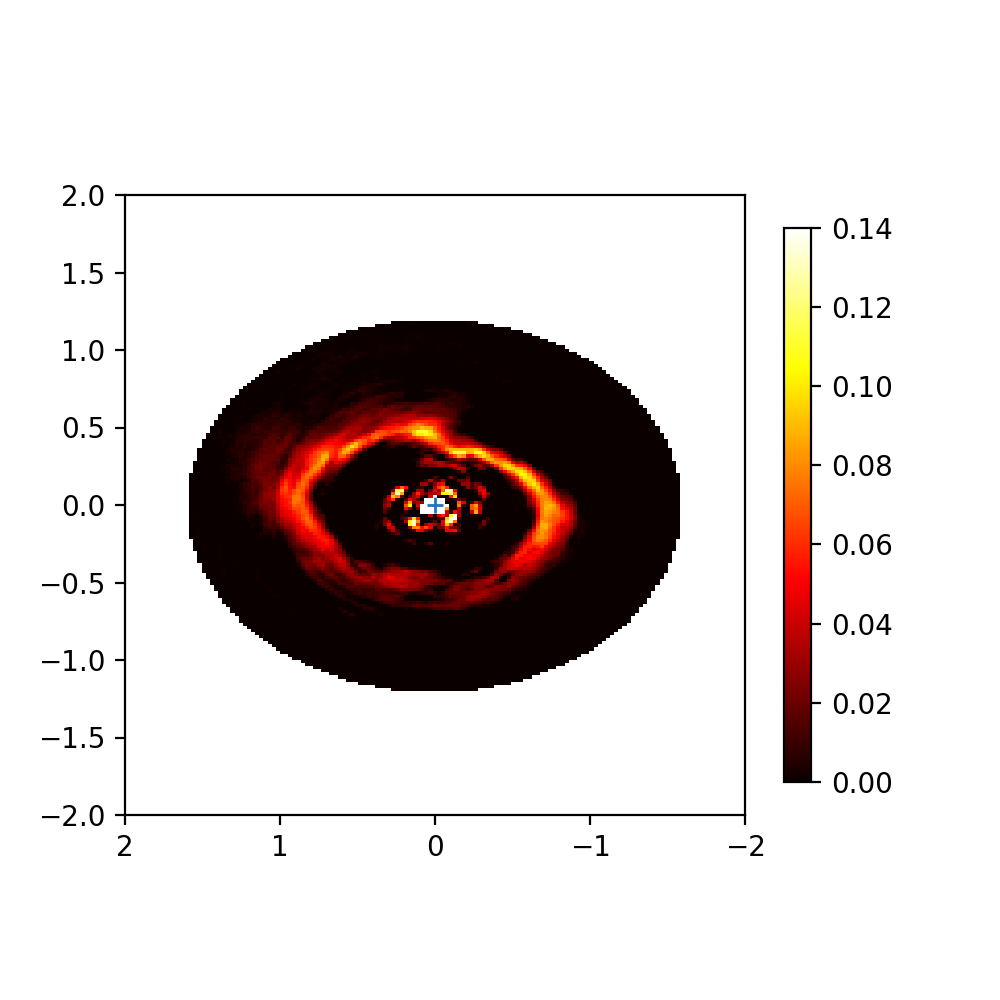

In [65]:
# number of pixels in RA, DEC dimensions
i, j = header['NAXIS1'], header['NAXIS2']
#rotate from i and j to x and y
RAo = 3600*((np.arange(i)-header['CRPIX1'])*header['CD1_1'] + (np.arange(j)-header['CRPIX2'])*header['CD1_2'])
DECo = 3600*((np.arange(i)-header['CRPIX1'])*header['CD2_1'] + (np.arange(j)-header['CRPIX2'])*header['CD2_2'])
#subtract the offsets
offRA = 0.03
offDEC = 0.01
RAo = RAo - offRA
DECo = DECo - offDEC
# #adjust for inclination and PA
# RAo = RAo
# DECo = DECo

#this next part is taken verbatim from the previous code block

# now convert these to two-dimensional arrays of RA and DEC offsets from the disk center for each pixel
dRA, dDEC = np.meshgrid(RAo, DECo)

incl, PA = 40.9, 74.5   # these were taken from Uyama et al. 2020 paper
# convert these to radians
inclr, PAr = np.radians(incl), np.radians(PA)

# deproject and rotate to new coordinate frame
xp = (dRA * np.cos(PAr) - dDEC * np.sin(PAr)) / np.cos(inclr)
yp = (dRA * np.sin(PAr) + dDEC * np.cos(PAr))


#plot in the new coordinates
fig = pylab.figure()
ax = fig.add_subplot(111)
fig.set_figheight(5)
fig.set_figwidth(5)
image = ax.imshow(img[10,:,:], cmap=mpl.cm.hot, origin = 'lower',vmin=-0.00009,vmax=0.14,
                  extent = (xp.max(),xp.min(),yp.min(),yp.max()))
cbar = fig.colorbar(image,ax =ax,shrink=0.72)
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "%.1f"%RAo))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "%.1f"%DECo))
ax.set_xlim([2,-2])
ax.set_ylim([-2,2])
#find the center offset manually
plt.plot(0,0,'+')
# ax.set_xlabel(r'$\Delta$ RA [arcsec]')
# ax.set_ylabel(r'$\Delta$ Dec [arcsec]')
#


In [6]:
# number of pixels in RA, DEC dimensions
nx, ny = header['NAXIS1'], header['NAXIS2']

# coordinate frames can be reconstructed from a mapping to pixels with header variables
# manually change the off values to the center of the image
offRA, offDEC = 100.002*0.0162, 99.9944*0.0162
# RAo = 3600 * header['XPIXSCAL'] * (np.arange(nx) - (header['XPIXSCAL'] - 1)) - offRA
# DECo = 3600 * header['YPIXSCAL'] * (np.arange(ny) - (header['YPIXSCAL'] - 1)) - offDEC


# RAo = (i-CRPIX1)*CD1_1 + (j-CRPIX2)*CD1_2 - offRA
# DECo = (i-CRPIX1)*CD2_1 + (j-CRPIX2)*CD2_2 -offDEC

# now convert these to two-dimensional arrays of RA and DEC offsets from the disk center for each pixel
dRA, dDEC = np.meshgrid(RAo, DECo)

# set the inclination and PA of the disk onto the sky-frame (degrees)
# again, these will need to be figured out in your case, e.g., by an elliptical gaussian fit
# ok to do by eye at least for this first try
incl, PA = 40.9, 74.5   # these were taken from Uyama et al. 2020 paper

# convert these to radians
inclr, PAr = np.radians(incl), np.radians(PA)

# deproject and rotate to new coordinate frame
xp = (dRA * np.cos(PAr) - dDEC * np.sin(PAr)) / np.cos(inclr)
yp = (dRA * np.sin(PAr) + dDEC * np.cos(PAr))

# now convert to polar coordinates (r in arcseconds, theta in degrees)
# note that theta starts along the minor axis (theta = 0), and rotates clockwise in the sky plane)
r = np.sqrt(xp**2 + yp**2)
theta = np.degrees(np.arctan2(yp, xp))

# radius and azimuth bin centers (and their widths)
rbins = np.linspace(0, 0.6, 300)    # in arcseconds
tbins = np.linspace(-180, 180, 181)     # in degrees
dr = np.abs(rbins[1] - rbins[0])
dt = np.abs(tbins[1] - tbins[0])

In [19]:
# initialize the (r, az)-map and radial profile
rtmap = np.empty((len(tbins), len(rbins)))
SBr, err_SBr = np.empty(len(rbins)), np.empty(len(rbins))

# loop through the bins to populate the (r, az)-map and radial profile
for i in range(len(rbins)):
    # identify pixels that correspond to the radial bin (i.e., in this annulus)
    in_annulus = ((r >= (rbins[i] - 0.6 * dr)) & (r < (rbins[i] + 0.6 * dr)))
    
    # accumulate the azimuth values and surface brightness values in this annulus
    az_annulus = theta[in_annulus]
    SB_annulus = image[in_annulus]
    
    # average the intensities (and their scatter) in the annulus
    SBr[i], err_SBr[i] = np.average(SB_annulus), np.std(SB_annulus)
    
    # populate the azimuthal bins for the (r, az)-map at this radius
    for j in range(len(tbins)):
        # identify pixels that correspond to the azimuthal bin
        in_wedge = ((az_annulus >= (tbins[j] - .60 * dt)) & (az_annulus < (tbins[j] + .6 * dt)))
        
        # if there are pixels in that bin, average the corresponding intensities
#         if (len(SB_annulus[in_wedge]) > 0):
        rtmap[j,i] = np.average(SB_annulus[in_wedge])
#         else:
#             rtmap[j,i] = -1e10    # this is a temporary placeholder; it will be fixed in next piece of code
            


<IPython.core.display.Javascript object>


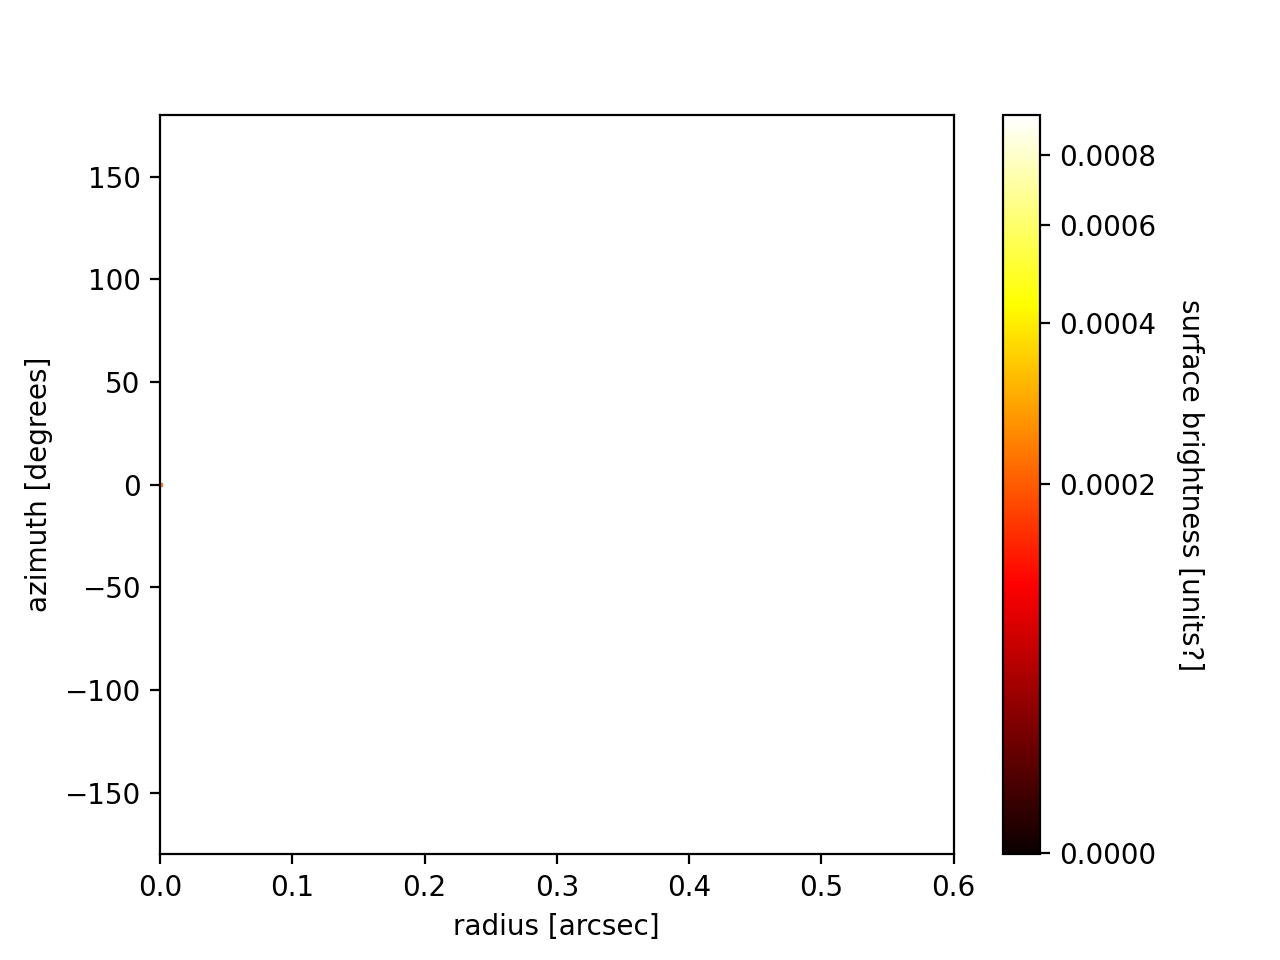

In [18]:
from astropy.visualization import ImageNormalize, AsinhStretch

# define the full (r, az)-map boundaries with a list of the min/max (r, az) bins
rtmap_bounds = (rbins.min(), rbins.max(), tbins.min(), tbins.max())

# set the radius and azimuth ranges you want to show
t_lims = [-180, 180]      
r_lims = [0, 0.6]

# now define the color-map, intensity limits, and stretch
cmap = mpl.cm.hot
vmin, vmax = -0.00009*0.00672160,0.14*0.00672160    # these are in mJy/beam units
# vmin, vmax = -0.00009,0.14    
norm = ImageNormalize(data = rtmap, vmin=vmin, vmax=vmax,stretch=AsinhStretch())

# cmap=mpl.cm.hot, origin = 'lower',vmin=-0.00009,vmax=0.14
# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(rtmap, origin='lower', cmap = cmap, extent=rtmap_bounds, 
               norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(t_lims)
ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [units?]', rotation=270, labelpad=17)

In [36]:
plt.imshow?